#Implementing and customising a VGG-16 CNN for flower identification
The aim of this notebook is to document my approach to adapting and implementing the VGG-16 CNN to identify the flowers recognition image library from Kaggle.

In [ ]:
!pip install split-folders
!pip install Augmentor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import Augmentor
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import splitfolders
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.applications import VGG16

---
##Data preparation

In [ ]:
split = (0.8, 0.1, 0.1)
seed = 22

splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/flowers", output="output", seed=seed, ratio=split, group_prefix=None, move=False)

Copying files: 4317 files [02:14, 32.14 files/s] 


Split folders is a nifty tool that can take a folder of images and split them according to a ratio into train, test, and val.

In [ ]:
train_dir = '/content/output/train'
validation_dir = '/content/output/val'
test_dir = '/content/output/test'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='categorical',
  seed=123,
  image_size=(224, 224),
  batch_size=32)

validation_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  labels='inferred',
  label_mode='categorical',
  seed=123,
  image_size=(224, 224),
  batch_size=32)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='categorical',
  seed=123,
  image_size=(224, 224),
  batch_size=32)

Found 3452 files belonging to 5 classes.
Found 430 files belonging to 5 classes.
Found 435 files belonging to 5 classes.


The three data sets I have made are actually generators that will feed images when called, in batches of 32. The images are also scaled to 224x224pxl. image_dataset_from_directory maintiains the folder name as the image label.

In [ ]:
preprocessing = Augmentor.Pipeline(train_dir)
preprocessing.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
preprocessing.flip_left_right(probability=0.5)
preprocessing.zoom_random(probability=0.5, percentage_area=0.8)
preprocessing.flip_top_bottom(probability=0.5)
preprocessing.shear(probability=0.5, max_shear_left=5, max_shear_right=5)
preprocessing.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)
preprocessing.resize(probability=1.0, width=224, height=224)

train_generator = preprocessing.keras_generator(batch_size=32, scaled=False)
images, labels = next(train_generator)

Initialised with 3452 image(s) found.
Output directory set to /content/output/train/output.

Augmentor is a useful class that creates a linear pipeline generator for images to be augmented. I have given a battery of augmentations for each image passed through this generator. The 224x224pxl size, 32 image batch size and lack of scaling has been maintained for coherency with the previously made dataset generators.

In [ ]:
sample_total = 4317
class_frequency = [764, 1052, 784, 733, 984]
class_weight = [sample_total/x for x in class_frequency]
class_weight_normalised = [x/sum(class_weight) for x in class_weight]
dict_class_weight = dict(zip(range(5), class_weight_normalised))
print(dict_class_weight)

{0: 0.22126633922238068, 1: 0.16069152392195704, 2: 0.215621789752422, 3: 0.23062412437366825, 4: 0.17179622272957196}


To account for the disparity in proportion of each flower class a normalised weight dictionary has been made. This will be passed to the compiler before training.

---
##The model itself

In [ ]:
def flower_cnn(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Input(shape=input_shape))
    model.add(layers.Rescaling(1./255))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

input_shape = (224, 224, 3)
num_classes = 5

model = flower_cnn(input_shape, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                        

The above architecture is the VGG-16 CNN. There is a change, this is the presence of preprocessing layers to rescale the iamges before they are fed into the model.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
      train_ds,
      epochs=10,
      validation_data=validation_ds)

test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

Epoch 1/10
108/108 [==============================] - 88s 539ms/step - loss: 1.6027 - accuracy: 0.2384 - val_loss: 1.5997 - val_accuracy: 0.2442
Epoch 2/10
108/108 [==============================] - 41s 375ms/step - loss: 1.6003 - accuracy: 0.2381 - val_loss: 1.5997 - val_accuracy: 0.2442
Epoch 3/10
108/108 [==============================] - 40s 366ms/step - loss: 1.6008 - accuracy: 0.2436 - val_loss: 1.5990 - val_accuracy: 0.2442
Epoch 4/10
108/108 [==============================] - 39s 359ms/step - loss: 1.5998 - accuracy: 0.2436 - val_loss: 1.5987 - val_accuracy: 0.2442
Epoch 5/10
108/108 [==============================] - 40s 365ms/step - loss: 1.5996 - accuracy: 0.2436 - val_loss: 1.5986 - val_accuracy: 0.2442
Epoch 6/10
108/108 [==============================] - 40s 364ms/step - loss: 1.5997 - accuracy: 0.2436 - val_loss: 1.5994 - val_accuracy: 0.2442
Epoch 7/10
108/108 [==============================] - 39s 362ms/step - loss: 1.5997 - accuracy: 0.2436 - val_loss: 1.5990 - val_ac

Due to the primary model becoming seemingly stuck in a local minima, the alternative model has been produced to account for class weight, augmented data, and a smaller optimiser learning rate.

In [ ]:
alternative_model = flower_cnn(input_shape, num_classes)

optimiser = Adam(learning_rate=0.0001)

alternative_model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

alt_history = alternative_model.fit(
      train_generator,
      steps_per_epoch = 107,
      epochs=10,
      validation_data=validation_ds,
      class_weight=dict_class_weight)

test_loss, test_acc = alternative_model.evaluate(test_ds)
print('Test accuracy:', test_acc)

Epoch 1/10
107/107 [==============================] - 98s 868ms/step - loss: 0.2921 - accuracy: 0.2845 - val_loss: 1.3296 - val_accuracy: 0.3698
Epoch 2/10
107/107 [==============================] - 88s 830ms/step - loss: 0.2581 - accuracy: 0.3934 - val_loss: 1.2847 - val_accuracy: 0.4140
Epoch 3/10
107/107 [==============================] - 90s 842ms/step - loss: 0.2327 - accuracy: 0.4904 - val_loss: 1.1660 - val_accuracy: 0.4628
Epoch 4/10
107/107 [==============================] - 89s 836ms/step - loss: 0.2243 - accuracy: 0.5181 - val_loss: 1.1896 - val_accuracy: 0.5116
Epoch 5/10
107/107 [==============================] - 88s 828ms/step - loss: 0.2146 - accuracy: 0.5359 - val_loss: 1.0699 - val_accuracy: 0.5023
Epoch 6/10
107/107 [==============================] - 88s 824ms/step - loss: 0.2059 - accuracy: 0.5444 - val_loss: 1.1368 - val_accuracy: 0.4953
Epoch 7/10
107/107 [==============================] - 92s 861ms/step - loss: 0.1971 - accuracy: 0.5961 - val_loss: 1.0072 - val_ac

---
##Result Functions Setup

In [ ]:
def plot_confusion_matrix(model, dataset, title):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        predictions = np.argmax(model.predict(images), axis=1)
        predicted_labels.extend(predictions)

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    tick_marks = np.arange(len(dataset.class_names))
    plt.xticks(tick_marks, dataset.class_names, rotation=45)
    plt.yticks(tick_marks, dataset.class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > np.max(cm) / 2 else 'black')

    plt.tight_layout()
    plt.show()

In [ ]:
img_path = ['/content/drive/MyDrive/Colab Notebooks/Assignment_3/my_flower_1.jpg',
            '/content/drive/MyDrive/Colab Notebooks/Assignment_3/my_flower_2.jpg']

def phone_camera_recognition(img_path, model):
    for path in img_path:
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img)

        img_array = np.expand_dims(img_array, axis=0)
        class_labels = {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

        prediction = model.predict(img_array)

        predicted_class_index = np.argmax(prediction)

        predicted_flower_type = class_labels.get(predicted_class_index)

        print("Predicted Flower Type: ", predicted_flower_type)
        print("Correct Flower Type: ", "Rose")

---
#Initial Results

Final Training Accuracy:  0.24362687766551971
Validation Accuracy:  0.24418604373931885
Difference:  -0.0005591660737991333
1/1 [==============================] - 0s 271ms/step


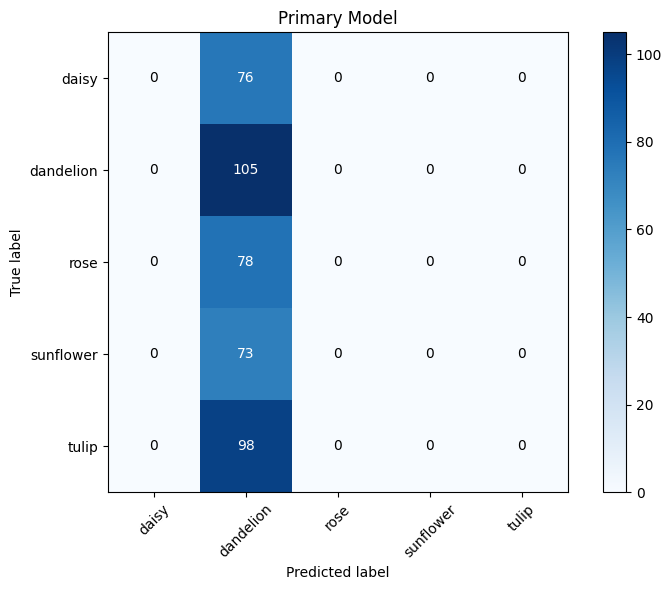

1/1 [==============================] - 1s 1s/step
Predicted Flower Type:  dandelion
Correct Flower Type:  Rose
1/1 [==============================] - 0s 18ms/step
Predicted Flower Type:  dandelion
Correct Flower Type:  Rose


In [ ]:
final_training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

print("Final Training Accuracy: ", final_training_accuracy)
print("Validation Accuracy: ", validation_accuracy)
print("Difference: ", final_training_accuracy - validation_accuracy)

plot_confusion_matrix(model, validation_ds, "Primary Model")

model_camera_predictions = phone_camera_recognition(img_path, model)

**Primary Model Outcome**

Without accounting for any factors and running the code by itself it can be seen there is approximately a 24.42% accuracy. This is reflected in the confusion matrix where the model predicting all classes to be Dandelions. Due tot he training accuracy and the validation accuracy being quite similar no overfitting has been observed.  

Final Alternative Training Accuracy:  0.6320093274116516
Alternative Validation Accuracy:  0.6023255586624146
Alternative Difference:  0.02968376874923706
1/1 [==============================] - 0s 446ms/step


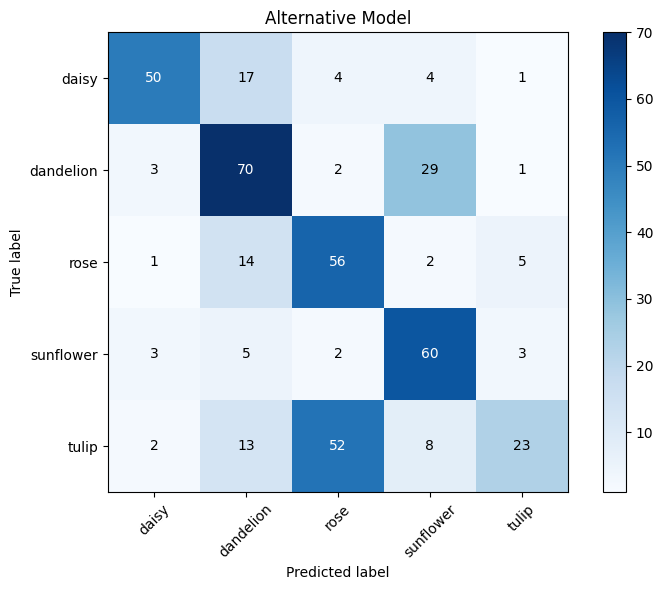

1/1 [==============================] - 0s 106ms/step
Predicted Flower Type:  rose
Correct Flower Type:  Rose
1/1 [==============================] - 0s 79ms/step
Predicted Flower Type:  dandelion
Correct Flower Type:  Rose


In [ ]:
final_training_accuracy = alt_history.history['accuracy'][-1]
validation_accuracy = alt_history.history['val_accuracy'][-1]

print("Final Alternative Training Accuracy: ", final_training_accuracy)
print("Alternative Validation Accuracy: ", validation_accuracy)
print("Alternative Difference: ", final_training_accuracy - validation_accuracy)

plot_confusion_matrix(alternative_model, validation_ds, "Alternative Model")

alt_model_camera_predictions = phone_camera_recognition(img_path, alternative_model)

**Alternative Model Outcome**

The alternative model with containing augmented data, a smaller learning rate for adam, and normalised class weights. This model also has the steps per epochs set to 107 to match the primary model. The reason this is specified, is due to the Augmentor generator being able to produce an indefinitely large amount of data.

The alternative model shows a marked improvement in accuracy. The accuracy being approximately 60.23%. The difference between training and validating accuracy is larger than the primary model but does not show signs of overfitting. The alternative model also performs better in it's confusion matrix. The performance is reflective of the 60.23% accuracy and displays that the tulip class is still under predicted while the rose class is over predicted.

---
##Architectural Optimisation

The alternative model has shown excellent progress, some minor architectural changes to the model should create a performant revised model. This is based on the idea that VGG-16 is a very deep neural network that was originally made witht he idea of 100 class classification. Being that this CNN is 5 taking some layers out and introducing some batch normalisation should improve results aand gain.

In [ ]:
def revised_flower_cnn(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Input(shape=input_shape))
    model.add(layers.Rescaling(1./255))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


input_shape = (224, 224, 3)
num_classes = 5

revised_model = revised_flower_cnn(input_shape, num_classes)
revised_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 220, 220, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 110, 110, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 108, 108, 128)    

In [ ]:
optimiser = Adam(learning_rate=0.0001)

revised_model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = revised_model.fit(
      train_generator,
      steps_per_epoch = 107,
      epochs=20,
      validation_data=validation_ds,
      class_weight=dict_class_weight)

test_loss, test_acc = revised_model.evaluate(test_ds)
print('Test accuracy:', test_acc)

Epoch 1/20
107/107 [==============================] - 101s 820ms/step - loss: 0.2660 - accuracy: 0.4810 - val_loss: 2.9070 - val_accuracy: 0.2442
Epoch 2/20
107/107 [==============================] - 89s 833ms/step - loss: 0.2046 - accuracy: 0.5695 - val_loss: 5.2414 - val_accuracy: 0.2442
Epoch 3/20
107/107 [==============================] - 89s 837ms/step - loss: 0.1750 - accuracy: 0.6425 - val_loss: 3.0187 - val_accuracy: 0.2442
Epoch 4/20
107/107 [==============================] - 88s 824ms/step - loss: 0.1732 - accuracy: 0.6489 - val_loss: 3.5833 - val_accuracy: 0.2442
Epoch 5/20
107/107 [==============================] - 91s 855ms/step - loss: 0.1598 - accuracy: 0.6901 - val_loss: 2.4092 - val_accuracy: 0.3930
Epoch 6/20
107/107 [==============================] - 88s 825ms/step - loss: 0.1478 - accuracy: 0.7138 - val_loss: 1.1909 - val_accuracy: 0.5442
Epoch 7/20
107/107 [==============================] - 90s 843ms/step - loss: 0.1518 - accuracy: 0.7114 - val_loss: 1.1003 - val_a

This showed a promising outcome, so I performed another 30 epochs totalling to 50.

In [ ]:
history = revised_model.fit(
      train_generator,
      steps_per_epoch = 107,
      epochs=30,
      validation_data=validation_ds,
      class_weight=dict_class_weight)

test_loss, test_acc = revised_model.evaluate(test_ds)
print('Test accuracy:', test_acc)

Epoch 1/30
107/107 [==============================] - 91s 854ms/step - loss: 0.0936 - accuracy: 0.8224 - val_loss: 0.7938 - val_accuracy: 0.7349
Epoch 2/30
107/107 [==============================] - 91s 856ms/step - loss: 0.0865 - accuracy: 0.8362 - val_loss: 0.7357 - val_accuracy: 0.7395
Epoch 3/30
107/107 [==============================] - 104s 977ms/step - loss: 0.0910 - accuracy: 0.8224 - val_loss: 0.7198 - val_accuracy: 0.7442
Epoch 4/30
107/107 [==============================] - 97s 916ms/step - loss: 0.0849 - accuracy: 0.8338 - val_loss: 0.7072 - val_accuracy: 0.7349
Epoch 5/30
107/107 [==============================] - 89s 837ms/step - loss: 0.0858 - accuracy: 0.8356 - val_loss: 0.6557 - val_accuracy: 0.7744
Epoch 6/30
107/107 [==============================] - 90s 848ms/step - loss: 0.0752 - accuracy: 0.8633 - val_loss: 0.7956 - val_accuracy: 0.6930
Epoch 7/30
107/107 [==============================] - 91s 853ms/step - loss: 0.0818 - accuracy: 0.8458 - val_loss: 0.9986 - val_a

---
##Final Result

Final Training Accuracy:  0.9001168012619019
Validation Accuracy:  0.7674418687820435
Difference:  0.1326749324798584
1/1 [==============================] - 0s 23ms/step


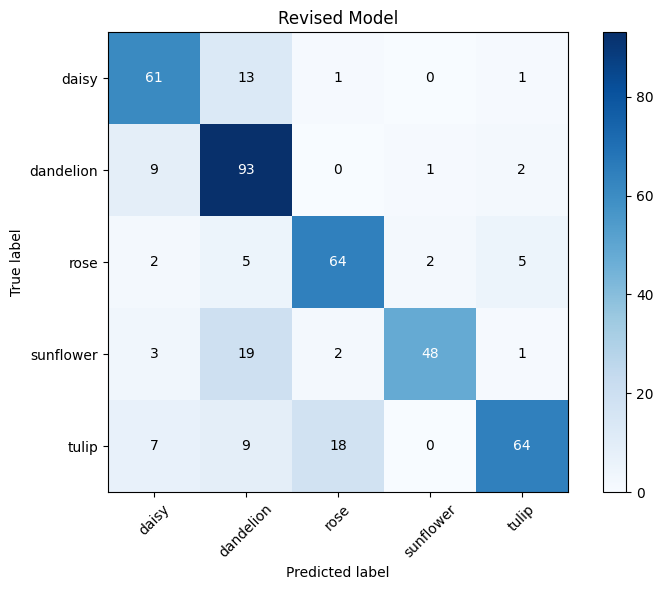

1/1 [==============================] - 0s 21ms/step
Predicted Flower Type:  rose
Correct Flower Type:  Rose
1/1 [==============================] - 0s 19ms/step
Predicted Flower Type:  daisy
Correct Flower Type:  Rose


In [ ]:
final_training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

print("Final Training Accuracy: ", final_training_accuracy)
print("Validation Accuracy: ", validation_accuracy)
print("Difference: ", final_training_accuracy - validation_accuracy)

plot_confusion_matrix(revised_model, validation_ds, "Revised Model")

revised_model_camera_predictions = phone_camera_recognition(img_path, revised_model)

---
##Fine Tuning

In [ ]:
def flower_transfer_learning(input_shape, num_classes):
    lifted_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in lifted_model.layers:
        layer.trainable = False

    top_model = lifted_model.output
    top_model = layers.Flatten()(top_model)
    top_model = layers.Dense(4096, activation='relu')(top_model)
    top_model = layers.Dropout(0.3)(top_model)
    top_model = layers.Dense(4096, activation='relu')(top_model)
    top_model = layers.Dense(4096, activation='relu')(top_model)
    top_model = layers.Dense(num_classes, activation='softmax')(top_model)

    model = models.Model(inputs=lifted_model.input, outputs=top_model)

    return model

input_shape = (224, 224, 3)
num_classes = 5

pretrained_model = flower_transfer_learning(input_shape, num_classes)
pretrained_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
optimiser = Adam(learning_rate=0.0001)

pretrained_model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = pretrained_model.fit(
      train_generator,
      steps_per_epoch = 107,
      epochs=20,
      validation_data=validation_ds,
      class_weight=dict_class_weight)

test_loss, test_acc = pretrained_model.evaluate(test_ds)
print('Test accuracy:', test_acc)

Epoch 1/20
107/107 [==============================] - 91s 771ms/step - loss: 0.8208 - accuracy: 0.6749 - val_loss: 0.8723 - val_accuracy: 0.7558
Epoch 2/20
107/107 [==============================] - 78s 737ms/step - loss: 0.2031 - accuracy: 0.7704 - val_loss: 1.1032 - val_accuracy: 0.7349
Epoch 3/20
107/107 [==============================] - 79s 745ms/step - loss: 0.1395 - accuracy: 0.8213 - val_loss: 0.7786 - val_accuracy: 0.8140
Epoch 4/20
107/107 [==============================] - 80s 755ms/step - loss: 0.1060 - accuracy: 0.8470 - val_loss: 0.7570 - val_accuracy: 0.8023
Epoch 5/20
107/107 [==============================] - 80s 750ms/step - loss: 0.1064 - accuracy: 0.8499 - val_loss: 0.8385 - val_accuracy: 0.7791
Epoch 6/20
107/107 [==============================] - 79s 739ms/step - loss: 0.0882 - accuracy: 0.8674 - val_loss: 0.7348 - val_accuracy: 0.8070
Epoch 7/20
107/107 [==============================] - 82s 770ms/step - loss: 0.0714 - accuracy: 0.8902 - val_loss: 0.7608 - val_ac

Final Training Accuracy:  0.9462617039680481
Validation Accuracy:  0.8232558369636536
Difference:  0.12300586700439453
1/1 [==============================] - 0s 158ms/step


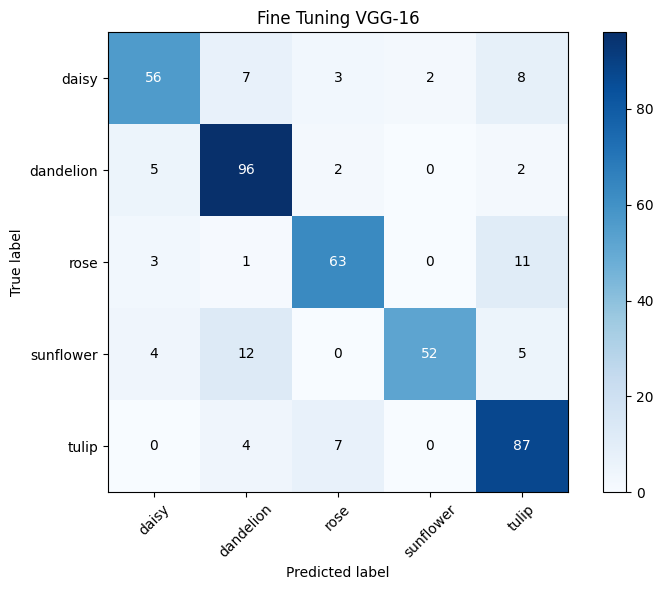

1/1 [==============================] - 0s 19ms/step
Predicted Flower Type:  rose
Correct Flower Type:  Rose
1/1 [==============================] - 0s 19ms/step
Predicted Flower Type:  daisy
Correct Flower Type:  Rose


In [ ]:
final_training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

print("Final Training Accuracy: ", final_training_accuracy)
print("Validation Accuracy: ", validation_accuracy)
print("Difference: ", final_training_accuracy - validation_accuracy)

plot_confusion_matrix(pretrained_model, validation_ds, "Fine Tuning VGG-16")

pretrained_model_camera_predictions = phone_camera_recognition(img_path, revised_model)

---
##Comparison

It can be seen that after only 50 epochs that the Revised Model has shown considerable performance gain. This is dispalyed by a final validation accuracy of approximately 76.74% and a difference of 13.26% gain in training accuracy. This is evidence that the training model is overfitting and that more data would be needed to extend the CNN further. The confusion matrix also displays a proficiency in classification but difficulty in tulips and sunflowers.

This model outperformed the Alternative Model at 10 epochs by approximately 16.51%. The confusion matrix reflects this imrpovement. 

When compared to a Fine Tuned VGG-16 model however, it can be seen that both the Alternative and Revised models underperform. The Fine Tuned VGG-16 displayed a final validation accuracy of 82.32% and a training accuracy of 94.62%. This also displays overfitting in training, unsurprising due to the shared data. 

This model at 10 epochs outperformed the Revised Model by approximately 4.58%. The confusion matrix is also more performant but still displays some difficulties with sunflowers and roses. 

All models had difficulty identifying the second user produced image. This could be due to the halo effect on the flower causing textural difficulties. Further refinement of the architecture, more raw data for training, and increased epochs could assist in performance.

It can also be seen that others using similar architecture and data sets were able to produce similar outcomes.  
- https://ieeexplore.ieee.org/document/9652277
- https://www.researchgate.net/publication/353990041_VGG-SCNet_A_VGG_Net_based_Deep_Learning_framework_for_Brain_Tumor_Detection_on_MRI_Images

---
#Exporting the models

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Flower CNN/primary_model.keras")
alternative_model.save("/content/drive/MyDrive/Colab Notebooks/Flower CNN/alternative_model.keras")
revised_model.save("/content/drive/MyDrive/Colab Notebooks/Flower CNN/revised_model.keras")
pretrained_model.save("/content/drive/MyDrive/Colab Notebooks/Flower CNN/pretrained_model.keras")